# Setup

In [1]:
# load the .env as environment variables
from dotenv import load_dotenv

load_dotenv()

True

# Quick Start

In [3]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Define a model client. You can use other model client that implements
# the `ChatCompletionClient` interface.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="YOUR_API_KEY",
)


# Define a simple function tool that the agent can use.
# For this example, we use a fake weather tool for demonstration purposes.
async def get_weather(city: str) -> str:
    """Get the weather for a given city."""
    return f"The weather in {city} is 73 degrees and Sunny."


# Define an AssistantAgent with the model, tool, system message, and reflection enabled.
# The system message instructs the agent via natural language.
agent = AssistantAgent(
    name="weather_agent",
    model_client=model_client,
    tools=[get_weather],
    system_message="You are a helpful assistant.",
    reflect_on_tool_use=True,
    model_client_stream=True,  # Enable streaming tokens from the model client.
)


# Run the agent and stream the messages to the console.
async def main() -> None:
    await Console(agent.run_stream(task="What is the weather in New York?"))


# NOTE: if running this inside a Python script you'll need to use asyncio.run(main()).
await main()

---------- user ----------
What is the weather in New York?
---------- weather_agent ----------
[FunctionCall(id='call_QPoh8vzSiLwwNGR4Kpyx0Z2C', arguments='{"city":"New York"}', name='get_weather')]
---------- weather_agent ----------
[FunctionExecutionResult(content='The weather in New York is 73 degrees and Sunny.', call_id='call_QPoh8vzSiLwwNGR4Kpyx0Z2C', is_error=False)]
---------- weather_agent ----------
The weather in New York is currently 73 degrees and sunny.


# Models

In [4]:
from autogen_ext.models.openai import OpenAIChatCompletionClient

openai_model_client = OpenAIChatCompletionClient(
    model="gpt-4o-2024-08-06",
    # api_key="sk-...", # Optional if you have an OPENAI_API_KEY environment variable set.
)

In [5]:
from autogen_core.models import UserMessage

result = await openai_model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(result)

finish_reason='stop' content='The capital of France is Paris.' usage=RequestUsage(prompt_tokens=15, completion_tokens=8) cached=False logprobs=None thought=None


# Messages

In [6]:
from autogen_agentchat.messages import TextMessage

text_message = TextMessage(content="Hello, world!", source="User")


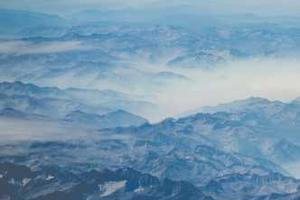

In [7]:
from io import BytesIO

import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
img

# Agents

In [8]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [ ]:
# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [ ]:
async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

# Teams

In [3]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [ ]:

# Create the agents.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
assistant = AssistantAgent("assistant", model_client=model_client)
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

# Create the termination condition which will end the conversation when the user says "APPROVE".
termination = TextMentionTermination("APPROVE")

# Create the team.
team = RoundRobinGroupChat([assistant, user_proxy], termination_condition=termination)

# Run the conversation and stream to the console.
stream = team.run_stream(task="Write a 4-line poem about the ocean.")
# Use asyncio.run(...) when running in a script.
await Console(stream)

---------- user ----------
Write a 4-line poem about the ocean.
---------- assistant ----------
Waves whisper secrets in a dance so grand,  
The azure stretch embraces golden sand.  
With each ebbing tide, dreams drift and flow,  
In the heart of the sea, wonders softly glow.  
TERMINATE
